# Model Training | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [2]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

# this file goes into the 'PROJECT_ROOT/src/' folder to work properly with the following paths

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  %cd '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/'
except:
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow


this_folder = os.path.realpath('.') # see https://stackoverflow.com/a/32711758/10866825 for details
lib_folder = os.path.join(this_folder, './lib/')
original_models_folder = os.path.join(this_folder, './../dev-models/_originals/') # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
original_datasets_folder = os.path.join(this_folder, './../dev-datasets/_originals/') # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
backgrounds_folder = os.path.join(this_folder, './../dev-datasets/_backgrounds/')
new_models_folder = os.path.join(this_folder, './../dev-models/')
new_datasets_folder = os.path.join(this_folder, './../dev-datasets/')
visualization_folder = os.path.join(this_folder, './../dev-visualization/')

dario_model_path = original_models_folder + 'v1_model_train_size_50000_rep_1.h5'
dario_train_path = original_datasets_folder + 'dario/v1_train.pickle'
dario_test_path = original_datasets_folder + 'dario/v1_test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(lib_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'keras_utils' from '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/src/keras_utils.py'>

## Dario's Model

In [3]:
old_model = tf.keras.models.load_model(dario_model_path)
old_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1, 1, 256)    1235200     image_input[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 256)          0           model_1[0][0]                    
__________________________________________________________________________________________________
1_dense (Dense)                 (None, 256)          65792       flatten_1[0][0]                  
____________________________________________________________________________________________

In [4]:
print('RES-NET')
old_model.get_layer("model_1").summary()

RES-NET
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________

## Dataset

Here, **regression variables** in the ground truth are used to retrieve **classification variables** (added to the dataset `y`) by discretizing continous values accordingly to arbitrary defined bin intervals. Train set size is reduced to avoid overloads.

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/version1/train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(31863, 3)
img_data shape: 	(31863,)
x_data shape: 		(31863, 60, 108, 3)
y_data shape: 		(31863, 4)
odom_dataset shape: 	(31863, 2)


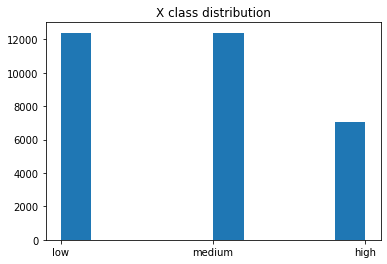

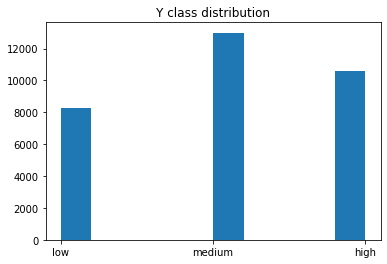

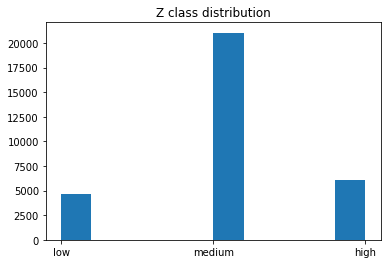

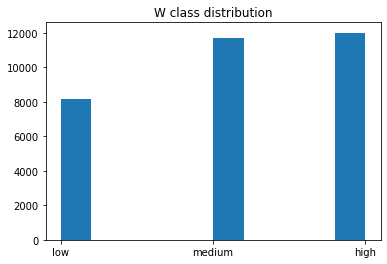

y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (31863,)
y_data_for_network single classification variable (4:8) 	 (31863, 3)


In [5]:
train_img, train_x, train_y, train_actual, train_odom = general_utils.get_dataset_from_pickle(dario_train_path, dataset_keep_ratio = 0.5, plot_actual_distribution = True)

## Training

### Single training, saving and demo

In [6]:
classification_only = True
var_index = None if not classification_only else None # set None if you want all classification vars
retrain_all = False

model = keras_utils.network_create(dario_model_path, retrain_all, var_index, classification_only)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 54, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 54, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 54, 64)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [7]:
model, history = keras_utils.network_train(model, train_x, train_y, var_index, classification_only)

fit
Epoch 1/2
349/349 - 10s - loss: 3.4689 - x_class_loss: 1.0043 - y_class_loss: 0.8130 - z_class_loss: 0.8099 - w_class_loss: 0.8417 - x_class_accuracy: 0.5110 - y_class_accuracy: 0.7015 - z_class_accuracy: 0.6644 - w_class_accuracy: 0.7130 - val_loss: 2.9771 - val_x_class_loss: 0.9366 - val_y_class_loss: 0.6568 - val_z_class_loss: 0.7311 - val_w_class_loss: 0.6527 - val_x_class_accuracy: 0.5756 - val_y_class_accuracy: 0.7879 - val_z_class_accuracy: 0.6902 - val_w_class_accuracy: 0.8362
Epoch 2/2
349/349 - 9s - loss: 2.7240 - x_class_loss: 0.8961 - y_class_loss: 0.5831 - z_class_loss: 0.6820 - w_class_loss: 0.5628 - x_class_accuracy: 0.5986 - y_class_accuracy: 0.8047 - z_class_accuracy: 0.7259 - w_class_accuracy: 0.8531 - val_loss: 2.5366 - val_x_class_loss: 0.8677 - val_y_class_loss: 0.5243 - val_z_class_loss: 0.6404 - val_w_class_loss: 0.5043 - val_x_class_accuracy: 0.6264 - val_y_class_accuracy: 0.8257 - val_z_class_accuracy: 0.7515 - val_w_class_accuracy: 0.8670


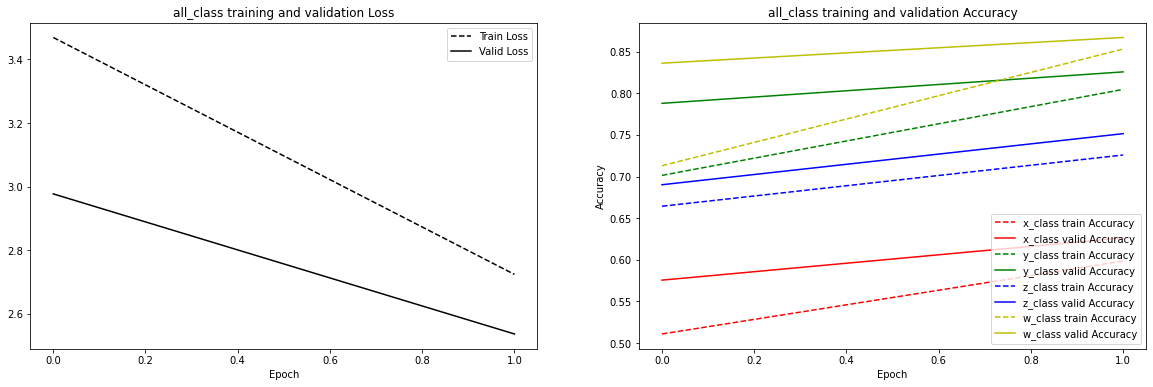

In [10]:
keras_utils.network_stats(history, var_index, classification_only, True, False, None, None)

In [ ]:
model_path = keras_utils.network_save(model, new_models_folder, 'classic', var_index, '', save_plot = False)

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/v1-20200923-165221 - classic (all_var) 


input shape (None, 60, 108, 3)
batch shape (1, 60, 108, 3)

actual regr [ 1.39874351 -0.25999165  0.03954268 -0.25842646]
actual class [0. 0. 1. 0.]
actual class ['low', 'low', 'medium', 'low']

pred class [1 0 1 1]
pred class ['medium', 'low', 'medium', 'medium']

network prediction
[[[0.27759904 0.48249123 0.23990971]]

 [[0.48345983 0.4294808  0.08705939]]

 [[0.10993472 0.66179395 0.22827137]]

 [[0.41603908 0.44115016 0.14281078]]]

--------------------------------------------------------------------

Predictions for variable x_class
Top 1 predicted class:     Pr(Class=medium [index=1]) = 0.482
Top 2 predicted class:     Pr(Class=low    [index=0]) = 0.278
Top 3 predicted class:     Pr(Class=high   [index=2]) = 0.240

Predictions for variable y_class
Top 1 predicted class:     Pr(Class=low    [index=0]) = 0.483
Top 2 predicted class:     Pr(Class=medium [index=1]) = 0.429
Top 3 predicted class:     Pr(Class=high   [index=2]) = 0.087

Predictions for variable z_class
Top 1 predicted

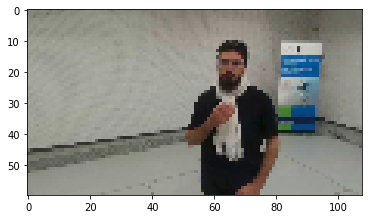

In [8]:
keras_utils.network_demo(model, train_x, train_img, train_actual, var_index, classification_only)

### Train all variants + GradCAM demo

Epoch 1/20
349/349 - 5s - loss: 3.5698 - x_class_loss: 1.0122 - y_class_loss: 0.8632 - z_class_loss: 0.8025 - w_class_loss: 0.8919 - x_class_accuracy: 0.5101 - y_class_accuracy: 0.6361 - z_class_accuracy: 0.6736 - w_class_accuracy: 0.6398 - val_loss: 2.9916 - val_x_class_loss: 0.9285 - val_y_class_loss: 0.6510 - val_z_class_loss: 0.7651 - val_w_class_loss: 0.6470 - val_x_class_accuracy: 0.6201 - val_y_class_accuracy: 0.8011 - val_z_class_accuracy: 0.6634 - val_w_class_accuracy: 0.8513
Epoch 2/20
349/349 - 4s - loss: 2.7888 - x_class_loss: 0.9077 - y_class_loss: 0.6103 - z_class_loss: 0.6692 - w_class_loss: 0.6016 - x_class_accuracy: 0.6026 - y_class_accuracy: 0.8046 - z_class_accuracy: 0.7344 - w_class_accuracy: 0.8255 - val_loss: 2.5258 - val_x_class_loss: 0.8475 - val_y_class_loss: 0.5030 - val_z_class_loss: 0.6869 - val_w_class_loss: 0.4885 - val_x_class_accuracy: 0.6540 - val_y_class_accuracy: 0.8363 - val_z_class_accuracy: 0.7093 - val_w_class_accuracy: 0.8585
Epoch 3/20
349/349 -

<Figure size 432x288 with 0 Axes>

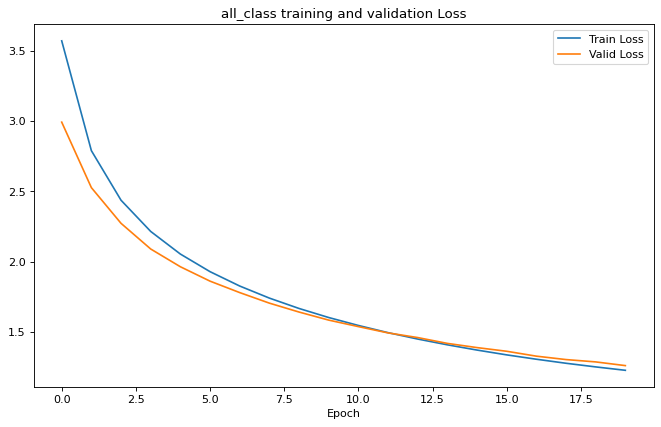

<Figure size 432x288 with 0 Axes>

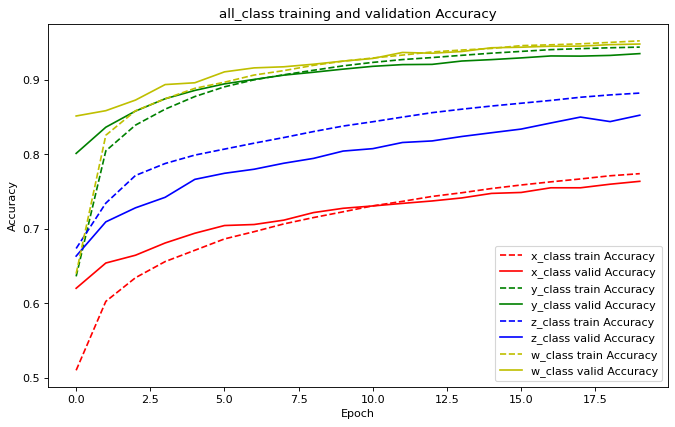

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/v1_all_class.h5
Epoch 1/20
349/349 - 3s - loss: 1.0139 - accuracy: 0.5026 - val_loss: 0.9352 - val_accuracy: 0.6001
Epoch 2/20
349/349 - 3s - loss: 0.9103 - accuracy: 0.5978 - val_loss: 0.8552 - val_accuracy: 0.6543
Epoch 3/20
349/349 - 3s - loss: 0.8535 - accuracy: 0.6314 - val_loss: 0.8030 - val_accuracy: 0.6686
Epoch 4/20
349/349 - 3s - loss: 0.8131 - accuracy: 0.6551 - val_loss: 0.7687 - val_accuracy: 0.6827
Epoch 5/20
349/349 - 3s - loss: 0.7817 - accuracy: 0.6699 - val_loss: 0.7450 - val_accuracy: 0.7002
Epoch 6/20
349/349 - 3s - loss: 0.7555 - accuracy: 0.6867 - val_loss: 0.7189 - val_accuracy: 0.7028
Epoch 7/20
349/349 - 3s - loss: 0.7331 - accuracy: 0.6988 - val_loss: 0.6983 - val_accuracy: 0.7114
Epoch 8/20
349/349 - 3s - loss: 0.7132 - accuracy: 0.7081 - val_loss: 0.6890 - val_accuracy: 0.7163
Epoch 9/20
349/349 - 3s - loss: 0.6958 - accuracy: 0.7

<Figure size 432x288 with 0 Axes>

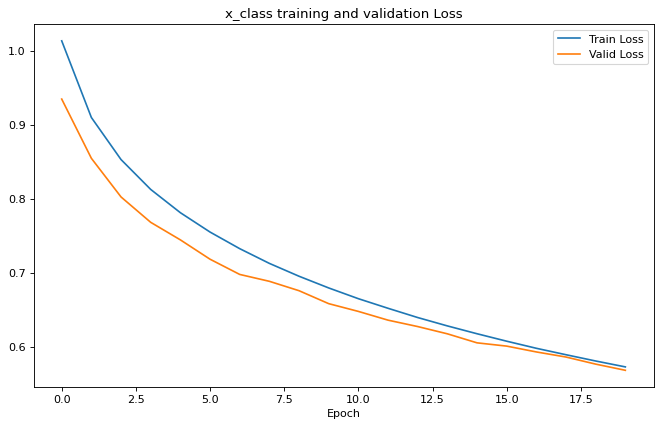

<Figure size 432x288 with 0 Axes>

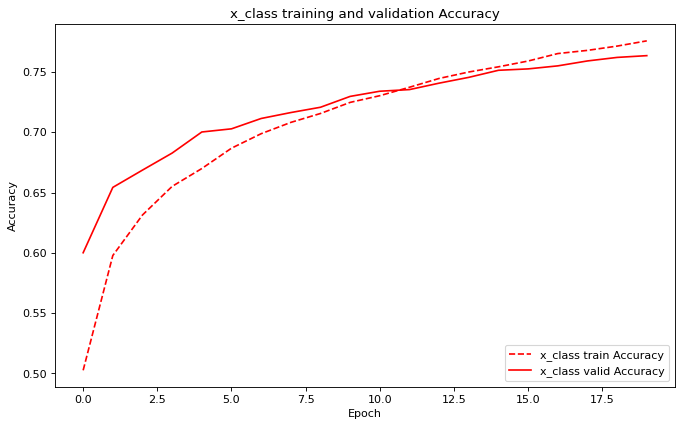

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/v1_x_class.h5
Epoch 1/20
349/349 - 3s - loss: 0.8530 - accuracy: 0.6578 - val_loss: 0.6523 - val_accuracy: 0.7890
Epoch 2/20
349/349 - 3s - loss: 0.6113 - accuracy: 0.7937 - val_loss: 0.5090 - val_accuracy: 0.8296
Epoch 3/20
349/349 - 3s - loss: 0.5045 - accuracy: 0.8317 - val_loss: 0.4307 - val_accuracy: 0.8528
Epoch 4/20
349/349 - 3s - loss: 0.4376 - accuracy: 0.8572 - val_loss: 0.3799 - val_accuracy: 0.8711
Epoch 5/20
349/349 - 3s - loss: 0.3897 - accuracy: 0.8763 - val_loss: 0.3438 - val_accuracy: 0.8834
Epoch 6/20
349/349 - 3s - loss: 0.3533 - accuracy: 0.8907 - val_loss: 0.3152 - val_accuracy: 0.8938
Epoch 7/20
349/349 - 3s - loss: 0.3244 - accuracy: 0.8996 - val_loss: 0.2931 - val_accuracy: 0.8993
Epoch 8/20
349/349 - 3s - loss: 0.3008 - accuracy: 0.9066 - val_loss: 0.2758 - val_accuracy: 0.9041
Epoch 9/20
349/349 - 3s - loss: 0.2812 - accuracy: 0.912

<Figure size 432x288 with 0 Axes>

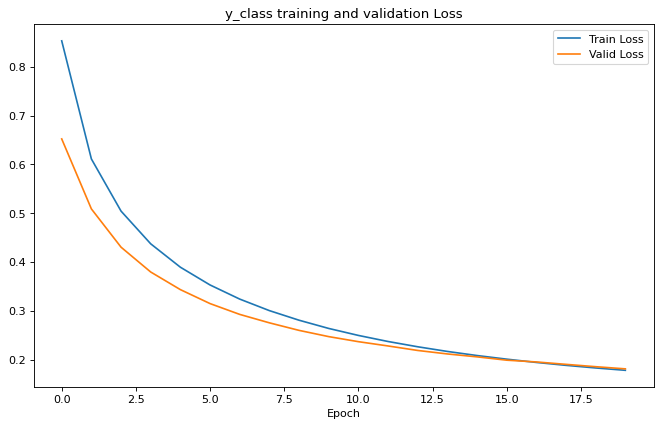

<Figure size 432x288 with 0 Axes>

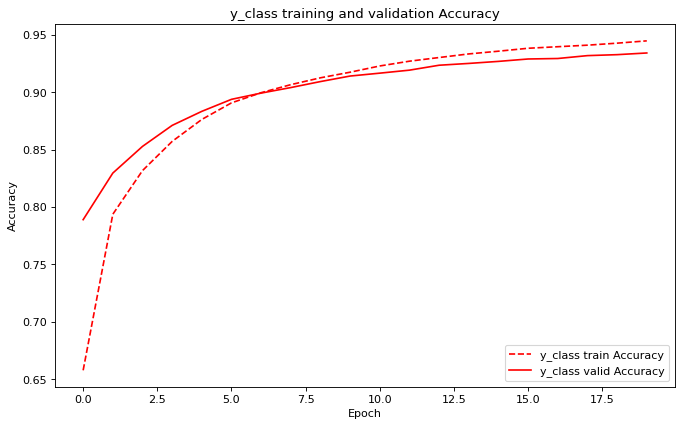

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/v1_y_class.h5
Epoch 1/20
349/349 - 3s - loss: 0.8243 - accuracy: 0.6697 - val_loss: 0.7864 - val_accuracy: 0.6571
Epoch 2/20
349/349 - 3s - loss: 0.6852 - accuracy: 0.7252 - val_loss: 0.6990 - val_accuracy: 0.7030
Epoch 3/20
349/349 - 3s - loss: 0.6072 - accuracy: 0.7660 - val_loss: 0.6451 - val_accuracy: 0.7240
Epoch 4/20
349/349 - 3s - loss: 0.5559 - accuracy: 0.7838 - val_loss: 0.6042 - val_accuracy: 0.7399
Epoch 5/20
349/349 - 3s - loss: 0.5183 - accuracy: 0.7953 - val_loss: 0.5745 - val_accuracy: 0.7506
Epoch 6/20
349/349 - 3s - loss: 0.4887 - accuracy: 0.8038 - val_loss: 0.5425 - val_accuracy: 0.7718
Epoch 7/20
349/349 - 3s - loss: 0.4641 - accuracy: 0.8115 - val_loss: 0.5227 - val_accuracy: 0.7754
Epoch 8/20
349/349 - 3s - loss: 0.4430 - accuracy: 0.8204 - val_loss: 0.5001 - val_accuracy: 0.7864
Epoch 9/20
349/349 - 3s - loss: 0.4245 - accuracy: 0.828

<Figure size 432x288 with 0 Axes>

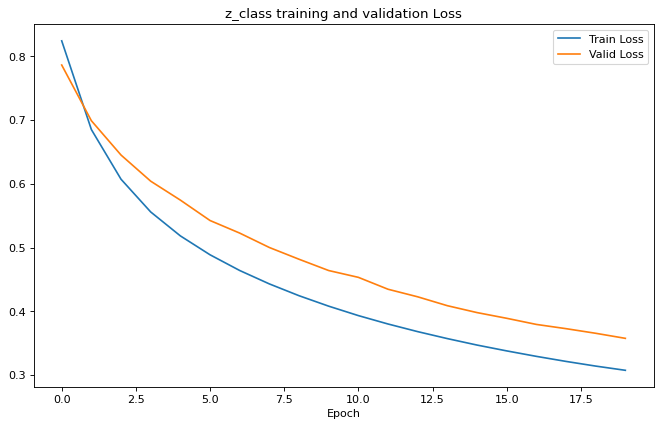

<Figure size 432x288 with 0 Axes>

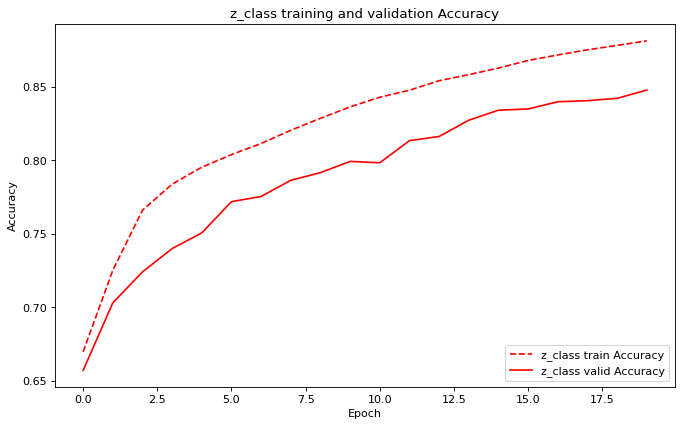

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/v1_z_class.h5
Epoch 1/20
349/349 - 3s - loss: 0.7895 - accuracy: 0.7540 - val_loss: 0.5980 - val_accuracy: 0.8354
Epoch 2/20
349/349 - 3s - loss: 0.5538 - accuracy: 0.8444 - val_loss: 0.4594 - val_accuracy: 0.8621
Epoch 3/20
349/349 - 3s - loss: 0.4556 - accuracy: 0.8681 - val_loss: 0.3845 - val_accuracy: 0.8801
Epoch 4/20
349/349 - 3s - loss: 0.3963 - accuracy: 0.8812 - val_loss: 0.3344 - val_accuracy: 0.9023
Epoch 5/20
349/349 - 3s - loss: 0.3545 - accuracy: 0.8936 - val_loss: 0.3026 - val_accuracy: 0.9083
Epoch 6/20
349/349 - 3s - loss: 0.3227 - accuracy: 0.9016 - val_loss: 0.2790 - val_accuracy: 0.9125
Epoch 7/20
349/349 - 3s - loss: 0.2975 - accuracy: 0.9108 - val_loss: 0.2584 - val_accuracy: 0.9178
Epoch 8/20
349/349 - 3s - loss: 0.2767 - accuracy: 0.9174 - val_loss: 0.2460 - val_accuracy: 0.9169
Epoch 9/20
349/349 - 3s - loss: 0.2591 - accuracy: 0.922

<Figure size 432x288 with 0 Axes>

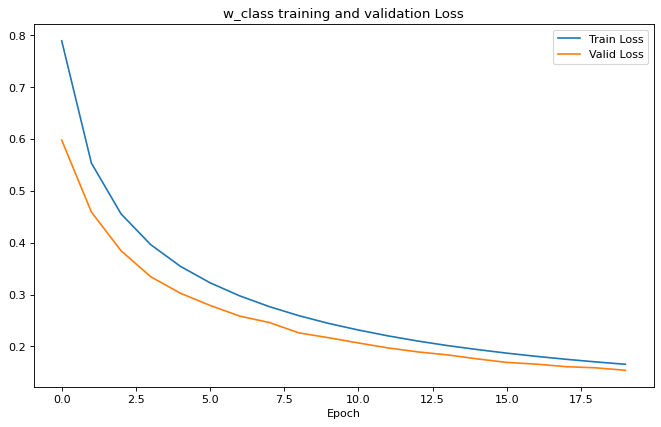

<Figure size 432x288 with 0 Axes>

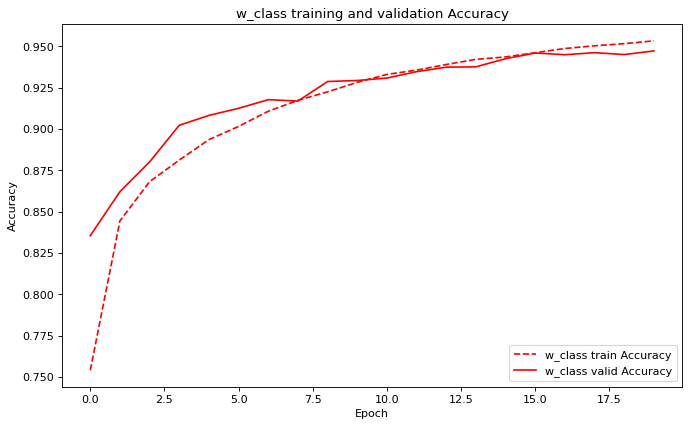

Model saved in /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/v1_w_class.h5


'/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/'

In [ ]:
### Training and export

exportvariants_folder = general_utils.create_datetime_folder(new_models_folder, 'variants')
retrain_all = False

keras_utils.network_export_variants(dario_model_path, exportvariants_folder, retrain_all, train_x, train_y, view_stats=True, save_stats=True)

In [ ]:
### Import models

vis_model_all, vis_model_vars = keras_utils.network_import_variants(exportvariants_folder)

Models imported from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200923_165240 variants/


In [ ]:
### GradCAM

vis_max_samples = 1000
vis_index_start = None
vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start = keras_utils.gradcam_data_select_predict_transform(vis_model_vars, train_img, train_x, train_actual, vis_max_samples, vis_index_start)

selected indexes are from 23549 to 24549 

x_class actual 		 ['low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',

In [ ]:
max_frames = 5
nplotted = np.min([max_frames, vis_max_samples])

var_types = [0, 1, 2, 3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3
frames = np.random.choice(range(vis_input.shape[0]), nplotted, p = keras_utils.get_wave_distribution(vis_input.shape[0]))
per_var__loss_folder = visualization_folder + 'gradcam/removebg/'

keras_utils.gradcam_comparison_varloss(
    vis_img, vis_input, vis_actuals, vis_predictions_best, vis_index_start,
    var_types, loss_types, vis_model_vars , frames, 
    per_var__loss_folder, notes = 'removebg', title = True, save = False
)

Output hidden; open in https://colab.research.google.com to view.